In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
import nltk
import csv
import time
import spotipy
import pickle
import Script.model_predict

from nltk.stem.porter import PorterStemmer
from spotipy.oauth2 import SpotifyClientCredentials
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Extracting data from spotipy

#### Extracting music data from spotipy

In [4]:

client_id = client_id  #replace this with you spotify client id
client_secret = client_secret #replace this with you spotify client secret

client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id, 
    client_secret=client_secret
)

for j in range(1):
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    # Create a CSV file and write the header row
    with open("tracks.csv", mode="a", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        if j == 0:
            writer.writerow([
                "id", "name", "artist",'artist_id', "album", "release_date", "popularity", "duration_ms", 
                "acousticness", "danceability", "energy", "instrumentalness", "key",
                "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature",
                "track_href", "uri", "valence"
            ])
        if True:
            offset = 1000
            limit = 50
            query = "indian song"
            total_tracks = 0
            for i in range(20):
                print(f"Retrieved 50 tracks (total: {50*(i+1)})")
                results = sp.search(q = query, type="track", limit=limit, offset=offset)
                tracks = results["tracks"]["items"]
                if not tracks:
                    break

                track_ids = [track["id"] for track in tracks]
                audio_features = sp.audio_features(track_ids)

                for i, track in enumerate(tracks):
                    try:
                        row = [
                            track["id"],
                            track["name"],
                            [track["artists"][i]['name'] for i in range(len(track["artists"]))],
                            [track["artists"][i]['id'] for i in range(len(track["artists"]))] ,
                            track["album"]["name"],
                            track["album"]["release_date"],
                            track["popularity"],
                            track["duration_ms"],
                            audio_features[i]["acousticness"],
                            audio_features[i]["danceability"],
                            audio_features[i]["energy"],
                            audio_features[i]["instrumentalness"],
                            audio_features[i]["key"],
                            audio_features[i]["liveness"],
                            audio_features[i]["loudness"],
                            audio_features[i]["mode"],
                            audio_features[i]["speechiness"],
                            audio_features[i]["tempo"],
                            audio_features[i]["time_signature"],
                            track["href"],
                            track["uri"],
                            audio_features[i]["valence"]
                        ]
                        writer.writerow(row)
                        # print(track["artists"][0]['id'])
                    except Exception as e:
                        pass
                total_tracks += len(tracks)
                offset += limit
                time.sleep(1)  # To avoid hitting the rate limit

                if total_tracks >= 100000:
                    break

print("Dataset saved to indian_songs_with_audio_features.csv")


#### Extracting artist data from spotipy

In [5]:

client_id = client_id
client_secret = client_secret

client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id, 
    client_secret=client_secret
)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Retrieve a list of Indian artists
results = sp.search(q="indian artists", type="artist", limit=1)
artists = results["artists"]["items"]
artist_ids = [artist["id"] for artist in artists]

# Retrieve the top tracks for each artist and extract their audio features
tracks = []
for artist_id in artist_ids:
    top_tracks = sp.artist_top_tracks(artist_id)["tracks"]
    track_ids = [track["id"] for track in top_tracks]
    audio_features = sp.audio_features(track_ids)

    for i, track in enumerate(top_tracks):
        track_features = {}
        if audio_features[i] is not None:
            track_features.update(audio_features[i])
            track_features.update({
                "artist_id": artist_id,
                "artist_name": track["artists"][0]["name"],
                "track_name": track["name"],
                "release_date": track["album"]["release_date"],
                "popularity": track["popularity"],
                "key": track_features["key"],
                "mode": track_features["mode"],
            })
            tracks.append(track_features)


print(df)
time.sleep(1)  # To avoid hitting the rate limit

# Convert the list of tracks to a DataFrame
df_tracks = pd.DataFrame(tracks)

# Group the tracks by artist and calculate the mean audio features
df_artists = df_tracks.groupby(["artist_id", "artist_name"]).agg({
    "acousticness": "mean",
    "danceability": "mean",
    "duration_ms": "mean",
    "energy": "mean",
    "instrumentalness": "mean",
    "liveness": "mean",
    "loudness": "mean",
    "speechiness": "mean",
    "tempo": "mean",
    "valence": "mean",
    "popularity": "mean",
    "key": lambda x: x.value_counts().index[0],
    "mode": lambda x: x.value_counts().index[0],
    "artist_id": "count",
    "genres": lambda x: sp.artist(x.iloc[0])["genres"],
}).reset_index()

# Rename the "artist_id" and "genres" columns
df_artists = df_artists.rename(columns={
    "artist_id": "count",
    "genres": "artist_genres"
})

# Save the DataFrame to a CSV file
df_artists.to_csv("artist.csv", index=False)

print("Dataset saved to indian_artists_with_audio_features.csv")


## Reading files

We have used kaggle dataset and the data after processing is final.csv 
https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks

In [6]:
track = pd.read_csv("tracks.csv")
track.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [7]:
track.shape

(586672, 20)

In [8]:
track.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [9]:
track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [10]:
track.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,586672.000000,5.866720e+05,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000
mean,27.570053,2.300512e+05,0.044086,0.563594,0.542036,5.221603,-10.206067,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464857,3.873382
std,18.370642,1.265261e+05,0.205286,0.166103,0.251923,3.519423,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764108,0.473162
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [11]:
#checking is there any duplicate value
track['id'].duplicated().unique()

array([False])

In [12]:
artist = pd.read_csv("artists.csv")
artist.head()

,artist_id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [13]:
artist.columns

Index(['artist_id', 'followers', 'genres', 'name', 'popularity'], dtype='object')

In [14]:
artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162095 entries, 0 to 1162094
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   artist_id   1162095 non-null  object 
 1   followers   1162084 non-null  float64
 2   genres      1162095 non-null  object 
 3   name        1162095 non-null  object 
 4   popularity  1162095 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 44.3+ MB


In [15]:
artist.describe()

,followers,popularity
count,1.162084e+06,1.162095e+06
mean,1.022070e+04,8.795961e+00
std,2.543995e+05,1.355777e+01
min,0.000000e+00,0.000000e+00
25%,1.000000e+01,0.000000e+00
50%,5.700000e+01,2.000000e+00
75%,4.170000e+02,1.300000e+01
max,7.890023e+07,1.000000e+02


In [16]:
#checking is there any duplicate value
artist['artist_id'].duplicated().unique()

array([False])

### DATA CLEANING

In [17]:
track['year'] = track['release_date'].str[:4]
track['year'].head()

0    1922
1    1922
2    1922
3    1922
4    1922
Name: year, dtype: object

In [18]:
#converting the id_artists which is in string format to list
track['id_artists'] = track['id_artists'].apply(ast.literal_eval) 

In [19]:
track['id_artists'].apply(lambda x: len(x))

0         1
1         1
2         1
3         1
4         1
         ..
586667    1
586668    1
586669    1
586670    2
586671    1
Name: id_artists, Length: 586672, dtype: int64

In [20]:
track['id_artists'][0][0]

'45tIt06XoI0Iio4LBEVpls'

In [21]:
#converting the artist name which is in string format to list
track['artists'] = track['artists'].apply(ast.literal_eval) 

In [22]:
track['artists']

0                               [Uli]
1                   [Fernando Pessoa]
2                   [Ignacio Corsini]
3                   [Ignacio Corsini]
4                       [Dick Haymes]
                     ...             
586667                      [阿YueYue]
586668                   [ROLE MODEL]
586669                      [FINNEAS]
586670    [Gentle Bones, Clara Benin]
586671                    [Afrosound]
Name: artists, Length: 586672, dtype: object

In [23]:
##converting the genres which is in string format to list
artist['genres'] = artist['genres'].apply(ast.literal_eval)

In [24]:

artist['genres'] 

0                      []
1                      []
2                      []
3                      []
4                      []
                ...      
1162090    [black comedy]
1162091                []
1162092                []
1162093    [black comedy]
1162094      [new comedy]
Name: genres, Length: 1162095, dtype: object

In [25]:
artist[artist['artist_id'] == track['id_artists'][4][0]]

,artist_id,followers,genres,name,popularity
137360,3BiJGZsyX9sJchTqcSA7Su,11327.0,"[adult standards, big band, easy listening, lo...",Dick Haymes,35


In [26]:
print([artist[artist['artist_id'] == track['id_artists'][4][i]].iloc[0]['genres'] for i in range(len(track['id_artists'][4]))])

[['adult standards', 'big band', 'easy listening', 'lounge', 'swing']]


In [27]:
merged = track.explode('id_artists').merge(artist, left_on='id_artists', right_on='artist_id')
grouped = merged.groupby('id')['genres'].apply(list).reset_index(name='combined_genres')
track = pd.merge(track, grouped, on='id')

In [28]:
track.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,combined_genres
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,...,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922,[[]]
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.2630,...,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922,[[]]
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922,"[[tango, vintage tango]]"
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922,"[[tango, vintage tango]]"
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,...,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922,"[[adult standards, big band, easy listening, l..."


In [29]:
track.shape

(576126, 22)

In [30]:
track['combined_genres'][576124]

[['chill r&b', 'indie cafe pop', 'singaporean pop'],
 ['opm', 'pinoy indie', 'pinoy singer-songwriter']]

In [31]:
track['combined_genres'].apply(lambda x : len(x))

0         1
1         1
2         1
3         1
4         1
         ..
576121    1
576122    1
576123    1
576124    2
576125    1
Name: combined_genres, Length: 576126, dtype: int64

In [32]:
def eval_genres(genres):
    if genres == [[]]:
        return []
    else:
        return sum(genres, [])

track['combined_genres'] = track['combined_genres'].apply(eval_genres)


In [33]:
track.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,combined_genres
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,...,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922,[]
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.2630,...,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922,[]
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922,"[tango, vintage tango]"
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922,"[tango, vintage tango]"
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,...,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922,"[adult standards, big band, easy listening, lo..."


In [34]:
# track['name'] = track['name'].apply(lambda x : x.replace(" ",""))
track['artists'] = track['artists'].apply(lambda x : [i.replace(" ","") for i in x])
track['combined_genres'] = track['combined_genres'].apply(lambda x : [i.replace(" ","") for i in x])

In [35]:
track.isna().sum()

id                  0
name                0
popularity          0
duration_ms         0
explicit            0
artists             0
id_artists          0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
year                0
combined_genres     0
dtype: int64

In [36]:
# #combining the all important tags
track['tag'] = track['artists'] + track['combined_genres'] + track.apply(lambda row: row['name'] + ',' + row['year'], axis=1).apply(lambda x: x.split(','))

#since we are working for 2015-2021 therefore we will not include year.
track['tag'] = track['artists'] + track['combined_genres'] + track.apply(lambda row: row['name'], axis=1).apply(lambda x: x.split(','))




In [37]:
track.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,combined_genres,tag
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,...,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922,[],"[Uli, Carve]"
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[FernandoPessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.2630,...,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922,[],"[FernandoPessoa, Capítulo 2.16 - Banquero Anar..."
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[IgnacioCorsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,...,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922,"[tango, vintagetango]","[IgnacioCorsini, tango, vintagetango, Vivo par..."
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[IgnacioCorsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,...,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922,"[tango, vintagetango]","[IgnacioCorsini, tango, vintagetango, El Prisi..."
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[DickHaymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,...,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922,"[adultstandards, bigband, easylistening, loung...","[DickHaymes, adultstandards, bigband, easylist..."


Since our data is quite high and our maching can not handle


we are using using song that are released between 2015 - 2021

In [141]:
# new_df = track[['id', 'name','tag']].where(track['year'].astype(int) > 2012 ).dropna()
# new_df.head()

new_df = track[['id', 'name','tag']].where(track['year'].astype(int) > 2015 ).dropna()
new_df

,id,name,tag
39438,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,"[FrankSinatra, adultstandards, easylistening, ..."
39442,19oquvXf3bc65GSqtPYA5S,It Was A Very Good Year - Live At The Sands Ho...,"[FrankSinatra, adultstandards, easylistening, ..."
39490,55qyghODi24yaDgKBI6lx0,"The Circle Game - Live at The 2nd Fret, Philad...","[JoniMitchell, canadiansinger-songwriter, folk..."
39492,00xemFYjQNRpOlPhVaLAHa,"Urge For Going - Live at The 2nd Fret, Philade...","[JoniMitchell, canadiansinger-songwriter, folk..."
39494,26g4FBGTB9YEj7q4HlblFf,"Brandy Eyes - Live at The 2nd Fret, Philadelph...","[JoniMitchell, canadiansinger-songwriter, folk..."
...,...,...,...
576120,0SjsIzJkZfDU7wlcdklEFR,John Brown's Song,"[GregoryOberle, instrumentallullaby, John Brow..."
576121,5rgu12WBIHQtvej2MdHSH0,云与海,"[阿YueYue, chineseviralpop, 云与海]"
576122,0NuWgxEp51CutD2pJoF4OM,blind,"[ROLEMODEL, altz, alternativer&b, bedroompop, ..."
576123,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,"[FINNEAS, altz, electropop, indiepop, laindie,..."


In [142]:
new_df.shape

(59594, 3)

In [143]:
new_df['tag'] = new_df['tag'].apply(lambda x : " ".join(x))

In [144]:
new_df.head()

,id,name,tag
39438,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,FrankSinatra adultstandards easylistening loun...
39442,19oquvXf3bc65GSqtPYA5S,It Was A Very Good Year - Live At The Sands Ho...,FrankSinatra adultstandards easylistening loun...
39490,55qyghODi24yaDgKBI6lx0,"The Circle Game - Live at The 2nd Fret, Philad...",JoniMitchell canadiansinger-songwriter folk fo...
39492,00xemFYjQNRpOlPhVaLAHa,"Urge For Going - Live at The 2nd Fret, Philade...",JoniMitchell canadiansinger-songwriter folk fo...
39494,26g4FBGTB9YEj7q4HlblFf,"Brandy Eyes - Live at The 2nd Fret, Philadelph...",JoniMitchell canadiansinger-songwriter folk fo...


In [145]:
new_df['tag'] = new_df['tag'].apply(lambda x : x.lower())
new_df.head()

,id,name,tag
39438,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,franksinatra adultstandards easylistening loun...
39442,19oquvXf3bc65GSqtPYA5S,It Was A Very Good Year - Live At The Sands Ho...,franksinatra adultstandards easylistening loun...
39490,55qyghODi24yaDgKBI6lx0,"The Circle Game - Live at The 2nd Fret, Philad...",jonimitchell canadiansinger-songwriter folk fo...
39492,00xemFYjQNRpOlPhVaLAHa,"Urge For Going - Live at The 2nd Fret, Philade...",jonimitchell canadiansinger-songwriter folk fo...
39494,26g4FBGTB9YEj7q4HlblFf,"Brandy Eyes - Live at The 2nd Fret, Philadelph...",jonimitchell canadiansinger-songwriter folk fo...


In [146]:
#stemming tags

ps = PorterStemmer()

def stem(text):
    y = []

    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)

In [147]:
new_df['tag'] = new_df['tag'].apply(stem)

## applying vectorization

In [148]:
genre_popularity = (new_df.tag.str.split(' ')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

-                  7411
pop                5186
traplatino         5110
latin              4945
reggaeton          4250
popdanc            3425
dancepop           3301
edm                3184
progressivehous    3002
(feat.             2999
Name: tag, dtype: int64

(-0.5, 999.5, 399.5, -0.5)

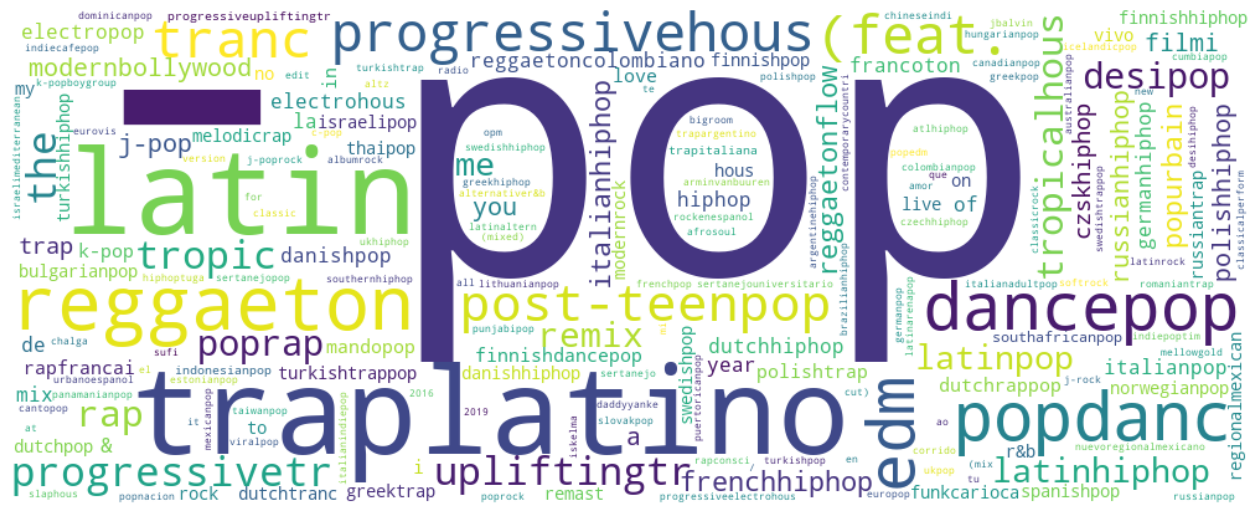

In [149]:


genre_wc = WordCloud(width=1000,height=400,background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())
plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

In [11]:

# reshape the 'tag' column of new_df to a one-dimensional array of strings
tag_array = new_df['tag'].values.reshape(-1)

# create a TfidfVectorizer object and fit it to the 'tag' array
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(tag_array)



In [166]:
new_df.to_csv("final.csv")

In [12]:
pickle.dump(tfidf , open("recomm_fit_transform.pickle", "wb"))

## Testing Code

In [11]:
new_df = pd.read_csv('final.csv', index_col=0)

In [12]:
new_df.columns

Index(['id', 'name', 'tag'], dtype='object')

In [2]:
model = pickle.load(open("recomm.pickle", "rb"))
tfidf = pickle.load(open("recomm_fit_transform.pickle", "rb"))

In [20]:
def predict_song(given_song, tfidf_matrix, new_df):
    # compute the TF-IDF vector of the given song

    given_song_tfidf = tfidf.transform([given_song])

    # compute the cosine similarity between the TF-IDF vector of the given song and all other TF-IDF vectors
    cosine_similarities = cosine_similarity(given_song_tfidf, tfidf_matrix)[0]

    # get the indices of the sorted cosine similarity scores
    sorted_indices = cosine_similarities.argsort()[::-1]

    # get the titles corresponding to the TF-IDF matrix
    titles = new_df['tag'].values

    li = []

    for i in sorted_indices[1:5]:
        li.append(new_df[new_df['tag'] == titles[i]][['id','name']])
        print(new_df[new_df['tag'] == titles[i]]['name'])
    return li

# given_song = input("Enter Songs/Artist")
given_song = 'arjit singh'
prediction = predict_song(given_song, model, new_df)

521891    Bekhayali (Arijit Singh Version)
Name: name, dtype: object
521774    Kaise Hua (From "Kabir Singh")
Name: name, dtype: object
521756    Bekhayali (From "Kabir Singh")
Name: name, dtype: object
521865    Mere Sohneya (From "Kabir Singh")
Name: name, dtype: object


In [8]:

given_song = 'arjit singh'
model = pickle.load(open(os.path.join("Model","recomm.pickle"), "rb"))
tfidf = pickle.load(open(os.path.join("Model","recomm_fit_transform.pickle"), "rb"))
new_df = pd.read_csv(os.path.join("Data",'final.csv'), index_col=0)

output = Script.model_predict.predict_song(given_song, model, new_df, tfidf, cosine_similarity)
print(output)
print(Script.model_predict.fetch_image(output))

['6aPMWbbdhDhiJHlknZb9Yx', '47Il9B5GJ2FEkiwiIH3xX0', '1y1rQTkWmrZdJmjwuK07GC', '1feANd8EfcDP5UqSvbheM3', '2IoZMG3RqiTmsy7Li3zGFg', '3lT4SlZVvqLhMeiuBv7gHW', '4OcvkkpF3xmyCGGY5IBlgi', '6gwnKOvdBKkTU4CQ7KpIAu', '2Fv2injs4qAm8mJBGaxVKU', '2U0BLmYoSESYOdwMxW2yA9', '0oyXtweTvTKBU8YlQFma0G', '1awtp7rf6ajhGY9BgzCHeZ', '7rMqbvNImA6wy8lxlNUMmj', '2zuF088LlogHBTb3wbk7C8', '4LtgkobW7PoVuwSvPjaGuq', '6FzQtkkLdph88iqQwvKEBM', '63rXrC9NNppuEzIxTbWr3w', '3lRIbuhF67NU6K72TiHvvM', '0jnYOrdCWc4M0uCVyj481C', '39X3dOZFThTSFpe7wqlJwk', '5egiiQYWp19Mda1TA4J4FR', '2jSxww1dgoXxQREvNiiIE1', '42C5Bbb4dHwS5OFMvtGkG2', '1ubDiR5IoDFOk1DOtXdWfL', '7BcRyPvhfTnkI4jZ5wLMBV']
['https://i.scdn.co/image/ab67616d0000b273bbc280510fa8d8c4e30f3b19', 'https://i.scdn.co/image/ab67616d0000b273c5545f737b16ad5ee767b62a', 'https://i.scdn.co/image/ab67616d0000b273ce1f4349305971b5beb75fcd', 'https://i.scdn.co/image/ab67616d0000b27390d98409f70719daa0dc0421', 'https://i.scdn.co/image/ab67616d0000b2738ae7ce46d1896e3e0fb86e70', 'https:/

In [9]:

client_id = '73642c549e6f42579477ced082e02387'
client_secret = '362e9b8202b44998aacc555d2178390a'

client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id, 
    client_secret=client_secret
)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


artist = sp.tracks(output)
print(artist)
print(artist['tracks'][0]['album']['images'][0]['url'])
print(artist['tracks'][1]['album']['images'][0]['url'])
print(artist['tracks'][2]['album']['images'][0]['url'])


{'tracks': [{'album': {'album_group': 'single', 'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4YRxDV8wJFPHPTeXepOstw'}, 'href': 'https://api.spotify.com/v1/artists/4YRxDV8wJFPHPTeXepOstw', 'id': '4YRxDV8wJFPHPTeXepOstw', 'name': 'Arijit Singh', 'type': 'artist', 'uri': 'spotify:artist:4YRxDV8wJFPHPTeXepOstw'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/1SyKki7JI1AZNKwgNMkn25'}, 'href': 'https://api.spotify.com/v1/artists/1SyKki7JI1AZNKwgNMkn25', 'id': '1SyKki7JI1AZNKwgNMkn25', 'name': 'Sachet-Parampara', 'type': 'artist', 'uri': 'spotify:artist:1SyKki7JI1AZNKwgNMkn25'}], 'available_markets': ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BN', 'BO', 'BR', 'BS', 'BT', 'BW', 'BY', 'BZ', 'CA', 'CD', 'CG', 'CH', 'CI', 'CL', 'CM', 'CO', 'CR', 'CV', 'CW', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DM', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'ET', 'FI', 'FJ', 'FM', 'FR